In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from tqdm import tqdm
import time
import os

In [2]:
path = "1d-simu"
if not os.path.exists(path):
    os.makedirs(path)

In [3]:
def create_initial_config(L,N,sigma):
    x = np.zeros(N)
    for i in range(N):
        correct_placement = 0
        while(correct_placement == 0):
            x_rand = np.random.rand()*L
            correct_placement = 1
            for j in range(i):
                dist = np.abs(x_rand-x[j])
                if dist < 2*sigma:
                    correct_placement = 0
        x[i] = x_rand
    
    v =  np.random.normal(0, 3, N)
    return x, v

#computes the collision time for one particle pair
def compute_tij(x,v,sigma):
    
    #x and v are the relative positions and velocities
    
    a = np.dot(v,v)
    b = 2*np.dot(v,x)
    c = np.dot(x,x) - (2*sigma)**2
    
    t1 = (-b+np.sqrt(b**2-4*a*c))/(2*a)
    t2 = (-b-np.sqrt(b**2-4*a*c))/(2*a)
    
    if t1 < 0 and t2 > 0:
        return t2
    elif t2 < 0 and t1 > 0:
        return t1
    elif t1 > 0 and t2 > 0:
        if t1 < t2:
            return t1
        else:
            return t2
    else:
        return 10000
    
    
       
#calculate all the collision times for all particles
def get_tij(x,v,N,sigma):

    tij = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            xij = x[i] - x[j]
            vij = v[i] - v[j]
            tij[i,j] = compute_tij(xij,vij,sigma)
    
    return tij



#also calculate bounce of times with the walls:
def get_boundary_collision(x,v,N,L,sigma):
    tr = np.zeros(N)
    for i in range(N):
        if v[i] < 0:
            tr[i] = (x[i]-sigma)/np.abs(v[i])
        else:
            tr[i] = (L-x[i]-sigma)/np.abs(v[i])
    return tr

def total_energy(v):
    return 0.5*np.sum(v**2)

In [17]:
def simulate(x,v,N,L,sigma,steps,e):
    
    counter = 0
    E = []
    
    while (counter < steps):
        #calculate next collision with wall or particle

        #first find the next particle collisions
        tij = get_tij(x,v,N,sigma) 
        tc = np.min(tij[np.nonzero(tij)]) # minimum time of next collision
        idx = np.where(tij == tc) # indices of the two particle that colide next
        i = idx[0][0]
        j = idx[1][0]

        #second find the next collision with the boundary
        t_boundary = get_boundary_collision(x,v,N,L,sigma)
        tb = np.min(t_boundary) # time of next boundary collision
        k = np.where(t_boundary == tb)[0][0] # index of the particle that collides with the boundary

        if tc < tb:
            # next collision is between particles
            for timer in range(int(tc/dt)):
                x = x+v*dt

                counter += 1
                E.append(total_energy(v))
                
                #save the plot
                name = str(counter)+'.png'
                fig = plt.figure(figsize=(10, 2))
                plt.yticks([])
                plt.xticks([])
                plt.ylim([-0.1,0.1])
                plt.xlim([0,10])
                for p in range(N):
                    plt.scatter(x[p],0,s=250)
                plt.savefig(os.path.join(path, name), dpi=300)
                plt.close(fig)
                
            #collision
            vi = np.copy(v[i])
            v[i] = e * np.copy(v[j])
            v[j] = e * np.copy(vi)

        else:
            # net collision is with the boundary
            for timer in range(int(tb/dt)):
                x = x+v*dt

                counter += 1
                E.append(total_energy(v))
                
                #save the plot
                name = str(counter)+'.png'
                fig = plt.figure(figsize=(10, 2))
                plt.yticks([])
                plt.xticks([])
                plt.ylim([-0.1,0.1])
                plt.xlim([0,10])
                for p in range(N):
                    plt.scatter(x[p],0,s=250)
                plt.savefig(os.path.join(path, name), dpi=300)
                plt.close(fig)
                
            #collision
            v[k] = -v[k]
           
        
    return np.array(E)

In [20]:
#create inital configuration
L = 10 # length of 1d line
N = 6 # number of particles
m = 1 # mass of particles
sigma = 0.11# radius of particle
x, v = create_initial_config(L,N,sigma)
end_time = 10
dt = 0.01
steps = int(end_time/dt)
e = 0.9 # restitution coefficient 

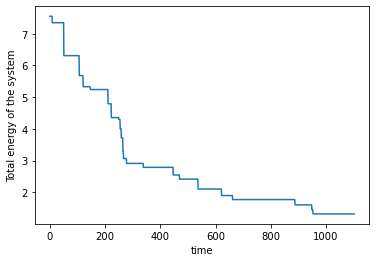

In [22]:
E = simulate(x,v,N,L,sigma,steps,e)

plt.figure()
plt.plot(E)
plt.xlabel("time")
plt.ylabel("Total energy of the system")
#plt.savefig("energy_with_damping.svg", dpi = 300)
plt.show()

In [28]:
N = [5,10,15,20,25,30]
L = 10
sigma = 0.11
end_time = 20
dt = 0.01
steps = int(end_time/dt)
e = 0.9 # restitution coefficient 
e_effs = []
for n in N:
    x, v = create_initial_config(L,n,sigma)
    E = simulate(x,v,n,L,sigma,steps,e)
    e_eff = np.sqrt(E[-1]/E[0])
    e_effs.append(e_eff)
    print(f"for N = {n} we get e_eff = {e_eff}")
    
plt.figure()
plt.plot(N,e_effs)
plt.xlabel("Number of particles")
plt.ylabel("effective restitution coefficient")
#plt.savefig("e_eff.svg", dpi = 300)
plt.show()

for N = 5 we get e_eff = 0.2699020623631841
for N = 10 we get e_eff = 0.15631572096428137
for N = 15 we get e_eff = 0.06630962340010801
for N = 20 we get e_eff = 0.03528724064041839
for N = 25 we get e_eff = 0.019841898170816483
for N = 30 we get e_eff = 0.01904165249747071
